# Propagation Path

Question 1: How many different control flow paths in SDC cases?

Question 2: How many different propagation paths in SDC cases?

Question 3: How to track the error?

Question 4: What's the probability that error propagate at this 10 element path will result into SDC?

Question 5: Measure how the error propagate through the program is a chanllenge problem

Question 6: How to trace the error propagate through the program.

Question 7: Error in different location has different meanings how to define them under same space.


##### Try to tracking the error in the complete program execution is difficult because of the complexity source code orgnization of the program. One of the problem of tracking the complete program execution is the path of the propagation.


##### You may want to only track the critical data variables to understand the propagation path.


Target data item
43766
43765
43763


In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
golden_run_path = "cg_simulation1/golden.log"
golden_run = pd.read_csv(golden_run_path,  sep=' ')
cg_fault_injection = pd.read_csv('cg_complete.csv')

In [3]:
number_of_instructions = {}

propagation_path = []

for index in range(100):
    if index in[15731, 16246, 17523]:
        continue
    
    file_path = "cg_simulation1/appstate_"+str(index)+".log"
    error_run = pd.read_csv(file_path,  sep=' ')
    
    
    #For different fault injection case, what is the number of different execution dynamic instructions
    if len(error_run) in number_of_instructions:
        number_of_instructions[len(error_run)] += 1
    else:
        number_of_instructions[len(error_run)] = 1
        
    #
    index = min(len(golden_run), len(error_run))
    #result = np.array(golden_run.value, dtype=float)[:index] - np.array(error_run.value, dtype=float)[:index]
    #propagation_elements = golden_run.line[np.where(result != 0)[0]]
    
    #path = "=>"
    #number_of_propagation_element = 5
    #for e in propagation_elements:
    #    if str(e) not in path:
    #        path += str(e)
    #        path += "=>"
    #        number_of_propagation_element -= 1
        
    #    if number_of_propagation_element == 0:
    #        break
    #if path not in propagation_path:
    #    propagation_path.append(path)

## What is the probability of the different number of storing dynamic instructions.
## What is the probability of SDC.

It's expected that if the program ends early, then there an unexpected crash during the program execution in the earlier stage. At the same time, if the program has more execution than it expected. It will have high chance causes silent data corruption.

In [4]:
cg_outcome = cg_fault_injection['outcome'].value_counts()

print(cg_outcome)
print(sum(cg_outcome))
#propagation_path

Masked    47284
SDC        4333
DUE         287
Name: outcome, dtype: int64
51904


In [5]:
number_of_instructions

{811: 88, 921: 4, 1031: 8}

# If you want to rewrite your code.

4. interactive fault injection campaign.

### 1. A sensitive analysis across the whole program with a mapping framework.
A desity scatter plot to understand the input and output sensitivity of the program. User can selective choose the high sensitive data and mapping back to the original visualization.
    
    a. how many clusters in the plot.
    
    b. Where is each of them comes from. 
    
    c. The sample that comes from the fault injection in same location.

#### 2. Explore function level resiliency of the program. What's the difference compare to the source code level?

    a.Explore the resiliency of different program component. Aggregate the data in variable level


#### 3. How to measure the impact of one variable/function over the other?
 


# The number of times a function is called.

In [7]:
counter = {}

line_to_func = {167:'readA', 175:'readB', 33:'waxpby', 25:'matvec', 48:'dot_r2', 75:'solve_cg', 76:'solve_cg',87:'solve_cg',57:'dot', 90:'solve_cg',91:'solve_cg',40:"daxpby", 82:'daxpby',83:'daxpby',84:'daxpby'}

for index, row in golden_run.iterrows():
    key = line_to_func[row['line']]
    if key not in counter:
        counter[key] = 1
    else:
        counter[key] += 1

In [8]:
number_of_instruction = sum(list(counter.values()))
for item in counter.items():
    print(item[0], item[1]/number_of_instruction * 100)

readA 7.891491985203452
readB 0.9864364981504316
waxpby 2.9593094944512948
matvec 55.24044389642416
dot_r2 5.9186189889025895
solve_cg 2.466091245376079
dot 5.9186189889025895
daxpby 18.618988902589393


# Error Propagation Analysis in one program component.

347


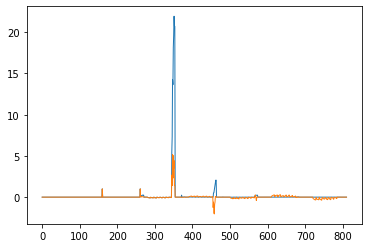

In [9]:
golden_run_path = "cg_simulation/golden.log"
golden_run = pd.read_csv(golden_run_path,  sep=' ', names=['file', 'linenum', 'variable', 'value'])
golden_run_value = np.array(golden_run.value)
##### this is a very interesting but werid case
##### There is a NAN occur during the computation, but the  error is masked at the end.
#index_range = [17341, 24381]

##### cg p_ap_dot first interation 64 experiment
#index_range = [15552, 15603]

#file_path = "cg_simulation1/appstate_"+str(17341)+".log"
#error_run = pd.read_csv(file_path,  sep=' ')

#for i in range(len(error_run.value)):
#    print(error_run.line[i], error_run.variable[i], error_run.value[i])
#print(len(error_run.value))

#print(error_run)
#data_set = {}


#golden_run_value = np.array(golden_run.value[0:800], dtype='float')

#for index in range(index_range[0], index_range[1]+1):
#    file_path = "cg_simulation/appstate_"+str(index)+".log"
#    error_run = pd.read_csv(file_path,  sep=' ', names=['file', 'linenum', 'variable', 'value'])

#    data_set[index] = golden_run_value - np.array(error_run.value[0:800], dtype='float')


##### a specific case line 75 case 10290
##### a specific case line 75 case 10296
indexs =  [10290, 10274]# 10288] #10297]# 10296, 10289]

delta_x = [65536, 1.0]# 1321922331132047.5]#, -307779.3308780107]
x_data = range(0, 811, 1)

for index,item in enumerate(indexs): 
    file_path = "cg_simulation/appstate_"+str(item)+".log"
    error_run = pd.read_csv(file_path,  sep=' ', names=['file', 'linenum', 'variable', 'value'])
    error_run_value = np.array(error_run.value)

    sensitivity_val = (error_run_value[0:811] - golden_run_value[0:811])/delta_x[index]
    sns.lineplot(x=x_data, y=sensitivity_val, sort=False, lw=1)
    
print(sensitivity_val.argmax())

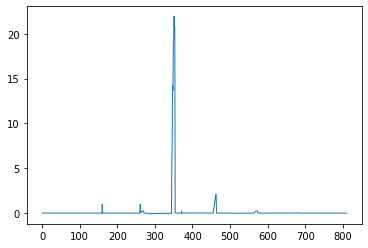

In [12]:
#for index in range(index_range[0], index_range[1]+1):
#    print(len(data_set[index].values))
#data_set[index] = golden_run.values - error_run.values   


x_data = range(0,811,1)
sns.lineplot(x=x_data, y=sensitivity_val, sort=False, lw=1)

#for index in range(index_range[0], index_range[0]+20): 
#    sns.lineplot(x=x_data, y=data_set[index], sort=False, lw=1)

## What role the truncation error is playing in the propagation analysis
## What's the threshold of different program components.
## How much error is masked by the truncate error and How much error is masked by the model feature